# test7-2：GSE163018_scRNA-seq_cerebral_organoid_cca
marker geneの数が100以上のclusterに絞って、gene_list（bed file）→LD score算出→S-LDSC

## Rでの作業

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#marker geneの数が100以上のclusterに絞ったfileの作成
#R
out_f="/home/oguma/work/seurat/test2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca"
out_f_genelist=paste0(out_f,"/genelist")
markers_merge_cca_cut_summarize <- read.csv(file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut_summarise.csv"), header = T)
markers_merge_cca_cut_summarize

cluster,marker_genes_n,marker_genes_anno_n
<int>,<int>,<int>
0,96,102
1,541,539
2,343,314
3,63,69
4,595,545
5,995,978
6,683,702
7,239,257
8,503,481


In [3]:
markers_merge_cca_cut_summarize_clustersover100 <- filter(markers_merge_cca_cut_summarize, marker_genes_anno_n>100)
markers_merge_cca_cut_summarize_clustersover100
write.csv(markers_merge_cca_cut_summarize_clustersover100, file = paste0(out_f_genelist,"/GSE163018_merge_cca_markers_cut_summarize_clustersover100.csv"), col.names = T, row.names = F)

cluster,marker_genes_n,marker_genes_anno_n
<int>,<int>,<int>
0,96,102
1,541,539
2,343,314
4,595,545
5,995,978
6,683,702
7,239,257
8,503,481
9,251,261


Warning message in write.csv(markers_merge_cca_cut_summarize_clustersover100, file = paste0(out_f_genelist, :
“ 'col.names' への変更の試みは無視されました ”


# ターミナルでの作業

In [ ]:
#login→working directoryへ移動
qlogin -l s_vmem=16G
export MKL_NUM_THREADS=1
export OMP_NUM_THREADS=1
export MKL_DOMAIN_NUM_THREADS=1
unset PROMPT_COMMAND
##unset PROMPT_COMMANDは改行のエラーを防ぐための呪文


####change to your working directory####
wd=/home/oguma/work/sldsc/test7-2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca_clustersonlyover100
mkdir $wd
####change to your working directory####

cd $wd
mkdir -p log

## data_listの作成

In [ ]:
#data_listの作成
mkdir -p info

out_f=/home/oguma/work/seurat/test2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca
out_f_genelist=${out_f}/genelist
awk -F ',' '{print "marker_gene_list_" $1}' ${out_f_genelist}/GSE163018_merge_cca_markers_cut_summarize_clustersover100.csv | awk 'NR>=2' > info/data_list

In [ ]:
export PATH=/home/k1_taka/miniconda3/envs/ldsc/bin:/home/k1_taka/miniconda3/bin:${PATH}

####change to your directory####
dd=/home/oguma/work/sldsc/test7-2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca_clustersonlyover100

####change to your data_list####
info=${dd}/info/data_list
num=`wc -l $info |  cut -d " " -f1` 
#numは、data_listの行数

In [ ]:
dir_path="${out_f_genelist}/GSE163018_merge_cca_marker_gene_list"
out_f2=${dir_path}/gene_region_v26_100KB_ext

## STEP1-1: LD Score (EUR)

yukioguma_arranged_ldscore_eur-v1_20241021.sh →
yukioguma_arranged_ldscore_eur-v1_20241028.sh

BEDFILE=/home/oguma/work/seurat/GSE163018/GSM4970298_organoid_H28126_scRNA/marker_gene_list/gene_region_v26_100KB_ext/${data}_region_hg19_ext100Kbp.bed
（両端から100kbpのばして、NAなくしたbed fileでldscoreを算出）
↓
BEDFILE=${out_f2}/${data}_region_hg19_ext100Kbp.bed

&qsubなげるときに.shのあとに${out_f2}を加えて、指定

In [ ]:
 #MAIN JOB
qsub -pe def_slot 1 \
   -l s_vmem=10G \
   -cwd \
   -t 1:${num} -tc 50 \
   -o log/ldscore_test_eur.log \
   -e log/ldscore_test_eur.error \
   /home/oguma/work/sldsc/test1/script/yukioguma_arranged_ldscore_eur-v1_20241028.sh ${dd} ${out_f2}
##Your job-array 107332040.1-14:1 ("yukioguma_arranged_ldscore_eur-v1_20241028.sh") has been submitted
##.sh ${} ${}みたいにやって、shell scriptでdd=${1}ってやったら1個目をshell script内で読み込める

## STEP2-1: S-LDSC (EUR)

In [ ]:
 #MAIN JOB
qsub -pe def_slot 1 \
   -l s_vmem=10G,mem_req=10G \
   -cwd \
   -t 1:${num} -tc 50 \
   -o log/sldsc_test.log \
   -e log/sldsc_test.error \
   /home/oguma/work/sldsc/test1/script/yukioguma_arranged_sldsc_eur-v1_20240905.sh ${dd}
##Your job-array 107333365.1-14:1 ("yukioguma_arranged_sldsc_eur-v1_20240905.sh") has been submitted
#tc 同時実行数を制御

# -log10pのbarplotの作成（Rでの作業）

In [1]:
.libPaths("~/R_4.3_library")

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
set.seed(1)
#乱数生成の種を「1」に設定し、その後の乱数生成が再現可能になる。

In [4]:
#install.packages("ggsci")
library(ggsci)

In [5]:
library(fs)

## X: CC毎の比較, y: -log10p, facet: sumstats (noexp)

In [6]:
##指定したディレクトリ内のファイルをリスト化
dir_path="/home/oguma/work/sldsc/test7-2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca_clustersonlyover100/sldsc/EUR"
filelist=dir(dir_path)

#modified LDSC (全mark含む)
enrichment_allsumstats_df=data.frame(matrix(rep(NA, 11), ncol=11))[0,]
for (file_n in filelist){
    sumstats_list=c("Lupus_langefeld", "RA_ishigaki", "PASS_ADHD_Demontis2018", "PASS_MDD_Howard2019", "PASS_MDD_Wray2018", "PASS_BipolarDisorder_Ruderfer2018", "PASS_Autism_Grove2019", "PASS_Schizophrenia_Pardinas2018", "PASS_Schizophrenia_Ruderfer2018", "PASS_Neuroticism", "PASS_Parkinsons_23andMe_Corces2020", "PASS_Alzheimers_Jansen2019", "PASS_Multiple_sclerosis")
    for (sumstats in sumstats_list){
        df=read.table(paste0(dir_path, "/", file_n, "/", sumstats,".results"), header=1)
        annotation_df=df[1, 2:10]
        
        new_df=data.frame(sumstatsname=sumstats,celltype=file_n, annotation_df)
        enrichment_allsumstats_df=rbind(enrichment_allsumstats_df, new_df)
    }
}
##1列目：sumstatsname、2列目：celltype、
##3列目以降：各ファイルの2行目(headerを除いて1行目)のみを抽出→2番目以降のフィールドを抽出（1番目のCategoryはカット）
##→すべてのファイルのデータを下の行に追加していく


In [7]:
enrichment_allsumstats_df <- enrichment_allsumstats_df %>% 
    mutate(minuslog10p=-log10(pnorm(-Coefficient_z.score,0,1)))

enrichment_allsumstats_df

sumstatsname,celltype,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z.score,minuslog10p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lupus_langefeld,marker_gene_list_0,0.009557034,0.001059646,0.006536934,0.1108760,0.68399196,1.953026e-01,-9.189244e-08,4.844105e-08,-1.89699521,0.01274243
RA_ishigaki,marker_gene_list_0,0.009557034,0.010251732,0.005024453,1.0726897,0.52573347,8.902047e-01,-8.139472e-09,1.600908e-08,-0.50842833,0.15837559
PASS_ADHD_Demontis2018,marker_gene_list_0,0.009557034,0.012977061,0.004277401,1.3578544,0.44756569,4.242360e-01,9.433198e-09,1.496864e-08,0.63019726,0.57793116
PASS_MDD_Howard2019,marker_gene_list_0,0.009557034,0.017608313,0.005544384,1.8424453,0.58013649,1.480375e-01,8.946671e-09,6.820884e-09,1.31165856,1.02311066
PASS_MDD_Wray2018,marker_gene_list_0,0.009557034,0.015928413,0.005285538,1.6666691,0.55305209,2.261405e-01,6.652654e-09,6.017554e-09,1.10554133,0.87139867
PASS_BipolarDisorder_Ruderfer2018,marker_gene_list_0,0.009557034,0.015740230,0.005197887,1.6469785,0.54388074,2.345044e-01,2.243094e-08,2.846507e-08,0.78801638,0.66686810
PASS_Autism_Grove2019,marker_gene_list_0,0.009557034,0.012926072,0.007930491,1.3525192,0.82980666,6.707753e-01,5.666069e-09,2.384074e-08,0.23766325,0.39139787
PASS_Schizophrenia_Pardinas2018,marker_gene_list_0,0.009557034,0.016459269,0.004406825,1.7222151,0.46110799,1.212738e-01,3.468736e-08,3.172583e-08,1.09334764,0.86289731
PASS_Schizophrenia_Ruderfer2018,marker_gene_list_0,0.009557034,0.013453762,0.003988900,1.4077340,0.41737847,3.285759e-01,1.126064e-08,2.635637e-08,0.42724551,0.47547373


In [8]:
#cell type同定ができたら
#metadata=read.table("/home/k1_taka/reference/LDSCORE/1000G_Phase3_cell_type_groups/names", header=1)
#metadata <- metadata %>%
    #mutate(celltype = paste0("cell_type_group.", file_num))
#    mutate(celltype = as.character(file_num))
    ##enrichment_allsumstats_dfのcelltypeがchrだったので揃える
#metadata
new.cluster.ids <- c("0_GABAergic neurons", "1_immature excitatory neurons", "2_mature neurons (GAD1+)", "3_unknown-1", "4_unknown-2", "5_mature neurons (GRIN2B+)",
    "6_neural stem cells", "7_neuroblasts-1", "8_radial glial cells-1", "9_mature excitatory neurons", "10_radial glial cells-2", "11_unknown-3", "12_astroglial cells", "13_radial glial cells-3", "14_radial glial cells-4", "15_neuroblasts-2")
metadata <- data.frame(
    celltype = paste0("marker_gene_list_",0:15),
    celltype2 = factor(new.cluster.ids, levels=rev(new.cluster.ids))
    )
metadata

celltype,celltype2
<chr>,<fct>
marker_gene_list_0,0_GABAergic neurons
marker_gene_list_1,1_immature excitatory neurons
marker_gene_list_2,2_mature neurons (GAD1+)
marker_gene_list_3,3_unknown-1
marker_gene_list_4,4_unknown-2
marker_gene_list_5,5_mature neurons (GRIN2B+)
marker_gene_list_6,6_neural stem cells
marker_gene_list_7,7_neuroblasts-1
marker_gene_list_8,8_radial glial cells-1


In [9]:
#cell_type_list <- c("Adrenal_Pancreas","CNS","Cardiovascular","Connective_Bone","GI","Hematopoietic","Kidney","Liver","SkeletalMuscle","Other")
#merge_df <- left_join(enrichment_allsumstats_df, metadata, by="celltype") %>%
#    separate(cell_type, c("cell_type2", ".bed"), sep="\\.") %>%
#    mutate(sumstatsname = factor(sumstatsname, levels=sumstats_list)) %>%
#    mutate(cell_type2 = factor(cell_type2, levels=rev(cell_type_list)))

merge_df <- left_join(enrichment_allsumstats_df, metadata, by="celltype") %>%
    mutate(sumstatsname = factor(sumstatsname, levels=sumstats_list))
merge_df

sumstatsname,celltype,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z.score,minuslog10p,celltype2
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Lupus_langefeld,marker_gene_list_0,0.009557034,0.001059646,0.006536934,0.1108760,0.68399196,1.953026e-01,-9.189244e-08,4.844105e-08,-1.89699521,0.01274243,0_GABAergic neurons
RA_ishigaki,marker_gene_list_0,0.009557034,0.010251732,0.005024453,1.0726897,0.52573347,8.902047e-01,-8.139472e-09,1.600908e-08,-0.50842833,0.15837559,0_GABAergic neurons
PASS_ADHD_Demontis2018,marker_gene_list_0,0.009557034,0.012977061,0.004277401,1.3578544,0.44756569,4.242360e-01,9.433198e-09,1.496864e-08,0.63019726,0.57793116,0_GABAergic neurons
PASS_MDD_Howard2019,marker_gene_list_0,0.009557034,0.017608313,0.005544384,1.8424453,0.58013649,1.480375e-01,8.946671e-09,6.820884e-09,1.31165856,1.02311066,0_GABAergic neurons
PASS_MDD_Wray2018,marker_gene_list_0,0.009557034,0.015928413,0.005285538,1.6666691,0.55305209,2.261405e-01,6.652654e-09,6.017554e-09,1.10554133,0.87139867,0_GABAergic neurons
PASS_BipolarDisorder_Ruderfer2018,marker_gene_list_0,0.009557034,0.015740230,0.005197887,1.6469785,0.54388074,2.345044e-01,2.243094e-08,2.846507e-08,0.78801638,0.66686810,0_GABAergic neurons
PASS_Autism_Grove2019,marker_gene_list_0,0.009557034,0.012926072,0.007930491,1.3525192,0.82980666,6.707753e-01,5.666069e-09,2.384074e-08,0.23766325,0.39139787,0_GABAergic neurons
PASS_Schizophrenia_Pardinas2018,marker_gene_list_0,0.009557034,0.016459269,0.004406825,1.7222151,0.46110799,1.212738e-01,3.468736e-08,3.172583e-08,1.09334764,0.86289731,0_GABAergic neurons
PASS_Schizophrenia_Ruderfer2018,marker_gene_list_0,0.009557034,0.013453762,0.003988900,1.4077340,0.41737847,3.285759e-01,1.126064e-08,2.635637e-08,0.42724551,0.47547373,0_GABAergic neurons


In [10]:
out_f="/home/oguma/work/sldsc/test7-2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca_clustersonlyover100"
out_f_plot=paste0(out_f,"/plot_2")
dir.create(out_f_plot)

Warning message in dir.create(out_f_plot):
“ '/home/oguma/work/sldsc/test7-2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca_clustersonlyover100/plot_2' はすでに存在します ”


In [11]:
#sumstats_list2=c("Lupus", "RA", "ADHD", "MDD_Howard2019", "MDD_Wray2018", "BD", "Autism", "SCZ_Pardinas2018", "SCZ_Ruderfer2018", "Neuroticism", "Parkinsons", "Alzheimers", "MS")
sumstats_list2=c("Lupus", "Rheumatoid arthritis", "ADHD", "MDD_Howard2019", "MDD_Wray2018", "Bipolar disorder", "Autism", "SCZ_Pardinas2018", "SCZ_Ruderfer2018", "Neuroticism", "Parkinsons", "Alzheimers", "Multiple sclerosis")
merge_df2 <- cbind(merge_df, sumstatsname2 = factor(sumstats_list2, levels=sumstats_list2))
head(merge_df2)

,sumstatsname,celltype,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z.score,minuslog10p,celltype2,sumstatsname2
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,Lupus_langefeld,marker_gene_list_0,0.009557034,0.001059646,0.006536934,0.110876,0.6839920,0.1953026,-9.189244e-08,4.844105e-08,-1.8969952,0.01274243,0_GABAergic neurons,Lupus
2,RA_ishigaki,marker_gene_list_0,0.009557034,0.010251732,0.005024453,1.072690,0.5257335,0.8902047,-8.139472e-09,1.600908e-08,-0.5084283,0.15837559,0_GABAergic neurons,Rheumatoid arthritis
3,PASS_ADHD_Demontis2018,marker_gene_list_0,0.009557034,0.012977061,0.004277401,1.357854,0.4475657,0.4242360,9.433198e-09,1.496864e-08,0.6301973,0.57793116,0_GABAergic neurons,ADHD
4,PASS_MDD_Howard2019,marker_gene_list_0,0.009557034,0.017608313,0.005544384,1.842445,0.5801365,0.1480375,8.946671e-09,6.820884e-09,1.3116586,1.02311066,0_GABAergic neurons,MDD_Howard2019
5,PASS_MDD_Wray2018,marker_gene_list_0,0.009557034,0.015928413,0.005285538,1.666669,0.5530521,0.2261405,6.652654e-09,6.017554e-09,1.1055413,0.87139867,0_GABAergic neurons,MDD_Wray2018
6,PASS_BipolarDisorder_Ruderfer2018,marker_gene_list_0,0.009557034,0.015740230,0.005197887,1.646979,0.5438807,0.2345044,2.243094e-08,2.846507e-08,0.7880164,0.66686810,0_GABAergic neurons,Bipolar disorder


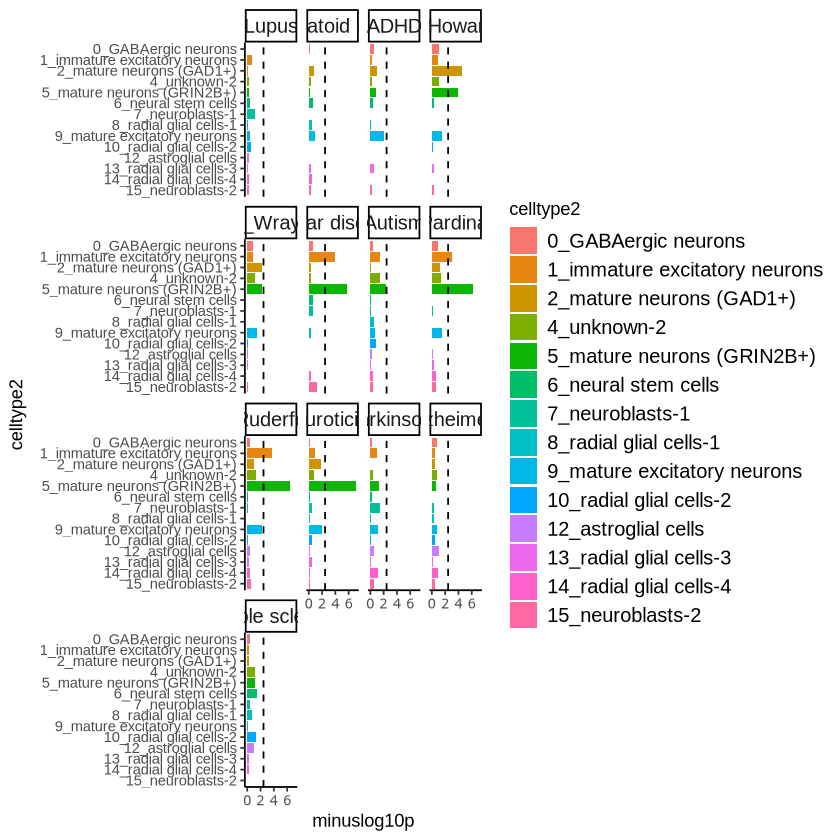

In [12]:
g <- ggplot(merge_df2, aes(x=minuslog10p, y=celltype2, fill=celltype2),color="black")+
    geom_bar(stat = "identity")+
    geom_vline(aes(xintercept=-log10(0.05/14)),linetype = "dashed", color = "black")+
    facet_wrap(~sumstatsname2)+
    guides(fill = guide_legend(reverse = TRUE))+
    scale_fill_manual(values=rev(c("#F8766D", "#E68613", "#CD9600", "#7CAE00", "#0BB702", "#00BE67","#00C19A", "#00BFC4", "#00B8E7", "#00A9FF", "#C77CFF", "#ED68ED", "#FF61CC", "#FF68A1")))+
    theme_classic()+
    theme(
    strip.text = element_text(size = 12),
    legend.text = element_text(size = 12)    # ここでフォントサイズを指定
    )
g

#ggsave(paste0(out_f_plot, "/barplot_minuslog10p_all_sumstatsnnotation_cutoff_labeled3.png"), g, width=12, height=6, dpi = 300)
ggsave(paste0(out_f_plot, "/barplot_minuslog10p_all_sumstatsnnotation_cutoff_labeled4.png"), g, width=12, height=6, dpi = 300)

In [17]:
markers_cut_summarize <- read.csv(file = "/home/oguma/work/seurat/test2_GSE163018_scRNA-seq_cerebral_organoid_integrate_cca/genelist/GSE163018_merge_cca_markers_cut_summarise.csv")
markers_cut_summarize <- markers_cut_summarize %>%
    mutate(celltype = paste0("marker_gene_list_",cluster))
markers_cut_summarize

cluster,marker_genes_n,marker_genes_anno_n,celltype
<int>,<int>,<int>,<chr>
0,96,102,marker_gene_list_0
1,541,539,marker_gene_list_1
2,343,314,marker_gene_list_2
3,63,69,marker_gene_list_3
4,595,545,marker_gene_list_4
5,995,978,marker_gene_list_5
6,683,702,marker_gene_list_6
7,239,257,marker_gene_list_7
8,503,481,marker_gene_list_8


In [23]:
merge_df2 <- inner_join(merge_df,markers_cut_summarize)

Joining with `by = join_by(celltype)`


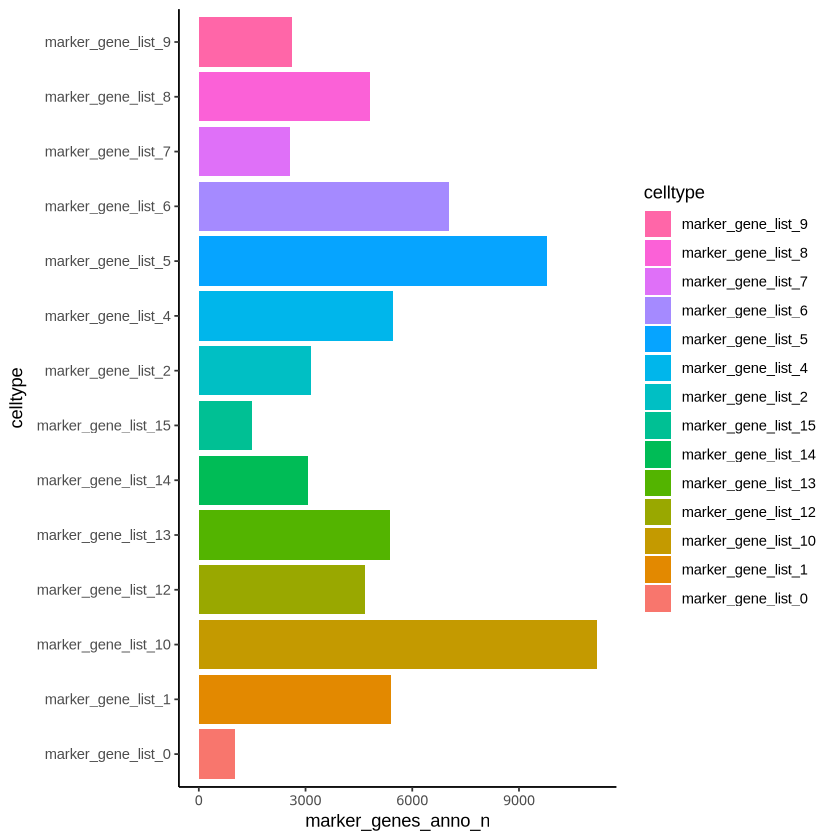

In [24]:
g <- ggplot(merge_df2, aes(x=marker_genes_anno_n, y=celltype, fill=celltype),color="black")+
    geom_bar(stat = "identity")+
    #facet_wrap(~sumstatsname)+
    guides(fill = guide_legend(reverse = TRUE))+
    #scale_fill_npg()+
    theme_classic()
g

ggsave(paste0(out_f, "/barplot_minuslog10p_all_sumstats_marker_genes_anno_n.pdf"), g, width=10, height=10)